# Analysis of Judgements with Multiple Raters

This notebook is an example of how we can analyze query / document pairs judgements in the case of multiple judges.

**Why?**
When we have one single rater for our judgements, we have no other choice than trusting the rating of that judge. However when we have multiple judges rating the same pairs, this gives us much more information about the actual rating of the pair.  For example if all judges disagree, it might be a good indicator that the pair is hard to judge, for example because the intent is not 100% clear.  Conversely, if all judges aree, we can have much higher confidence in this rating.

**Goal**
Analyze agreement between raters to measure confidence about each rating, in particular we would like to:

  - analyze the distribution of grades
  - measure raters's consistency
  - identify suspicious ratings in other to clean the dataset and make sure we only keep <query,document> for which we have enough confidence in the rating.


**Data**
For this we need a dataset with following information:
  
  - <query,document> pairs 
  - Each pair is rated by 3 different judges. In this example we consider a rating grade between 0 and 3:
      - `0`: document relevance is **poor**
      - `1`: document relevance is **fair**
      - `2`: document relevance is **good**
      - `3`: document relevance is **perfect**
      
The analysis would also work with other grade scale with minor changes in the code.

To get this data, we will directly get judgement book from Quepid, via the API. Any external data could also be used.

 


## Setup
Basic libraries needed in this analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random
import string
from js import fetch
from datetime import datetime
import random
from matplotlib import pyplot
from io import StringIO
%matplotlib inline

In [2]:
ratings = ['0-Bad', '1-Fair', '2-Good', '3-Perfect']

## Get Ratings From Books API

In [3]:
# You need to get your book_id from Quepid UI. You should be able to see it's content if you open <your-quepid-url>/api/books/1.json
BOOK_ID = 25

In [66]:
# Get content of the book in CSV format (could also use JSON)
res = await fetch(f'/api/books/{BOOK_ID}.csv')
res_str = await res.text()
df = pd.read_csv(StringIO(res_str))
df

,query,docid,charlie@flax.co.uk,epugh@opensourceconnections.com,eschramma@cas.org,dtaivpp@gmail.com,aarora@opensourceconnections.com,cmcollier@gmail.com,ben.w.trent@gmail.com,jeff@vin.com,cmarino@enterprise-knowledge.com,msfroh@gmail.com,peter@searchintuition.com,maximilian.werk@jina.ai,ryan.finley@ferguson.com
0,projector screen,325961,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,projector screen,47471,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,projector screen,126679,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,projector screen,254441,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,projector screen,325958,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2415,power supply,1667352,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2416,power supply,1667804,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2417,power supply,1667752,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2418,power supply,1667821,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
if df.shape[0] == 0:
    print('It Looks like your book is empty or does not exists')

In [6]:
#df.dropna(inplace=True)
df.shape

(0, 15)

In [29]:
df.loc[df['docid'] == '325961']

,query,docid,charlie@flax.co.uk,epugh@opensourceconnections.com,eschramma@cas.org,dtaivpp@gmail.com,aarora@opensourceconnections.com,cmcollier@gmail.com,ben.w.trent@gmail.com,jeff@vin.com,cmarino@enterprise-knowledge.com,msfroh@gmail.com,peter@searchintuition.com,maximilian.werk@jina.ai,ryan.finley@ferguson.com


In [30]:
raters = list(df.columns[2:])
raters

['charlie@flax.co.uk',
 'epugh@opensourceconnections.com',
 'eschramma@cas.org',
 'dtaivpp@gmail.com',
 'aarora@opensourceconnections.com',
 'cmcollier@gmail.com',
 'ben.w.trent@gmail.com',
 'jeff@vin.com',
 'cmarino@enterprise-knowledge.com',
 'msfroh@gmail.com',
 'peter@searchintuition.com',
 'maximilian.werk@jina.ai',
 'ryan.finley@ferguson.com']

In [67]:
# We need to filter to raters that we THINK might have some overlap
raters = [
    'Eric Pugh',
     'Atita Arora',
    'Benjamin Trent'
]

In [68]:
nb_raters = len(raters)

We just transform a bit the data so that it's easier to process:

In [69]:
df.rename(columns={rn:f'rating_{i}' for i,rn in enumerate(raters)}, inplace=True)
for i, rn in enumerate(raters):
    df[f'rater_{i}'] = rn
df

,query,docid,charlie@flax.co.uk,rating_0,eschramma@cas.org,dtaivpp@gmail.com,rating_1,cmcollier@gmail.com,rating_2,jeff@vin.com,cmarino@enterprise-knowledge.com,msfroh@gmail.com,peter@searchintuition.com,maximilian.werk@jina.ai,ryan.finley@ferguson.com,rater_0,rater_1,rater_2
0,projector screen,325961,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com
1,projector screen,47471,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com
2,projector screen,126679,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com
3,projector screen,254441,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com
4,projector screen,325958,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2415,power supply,1667352,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com
2416,power supply,1667804,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com
2417,power supply,1667752,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com
2418,power supply,1667821,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com


We flatten the data to have 1 rating per row:

In [70]:
df_overall = pd.concat([
    df[['query','docid',f'rating_{i}', f'rater_{i}']].rename(
        columns={f'rating_{i}':'rating', f'rater_{i}':'rater'}) for i in range(nb_raters)]).reset_index(drop=True)
df_overall.sort_values(by=['docid'], inplace=True)
df_overall

,query,docid,rating,rater
4063,iphone 11,1423,NaN,aarora@opensourceconnections.com
6483,iphone 11,1423,NaN,ben.w.trent@gmail.com
1643,iphone 11,1423,NaN,epugh@opensourceconnections.com
4065,iphone 11,1424,NaN,aarora@opensourceconnections.com
6485,iphone 11,1424,NaN,ben.w.trent@gmail.com
...,...,...,...,...
2383,windows 10,79583170,NaN,epugh@opensourceconnections.com
4803,windows 10,79583170,NaN,aarora@opensourceconnections.com
5879,samsung,79659021,NaN,ben.w.trent@gmail.com
3459,samsung,79659021,3.0,aarora@opensourceconnections.com


In [71]:
df_overall.dropna(inplace=True)

### Rating distribution per query
He we just want to plot the distribution of ratings for each query:


In [72]:
df_overall[['query', 'rating']].groupby('query').agg(['count', 'mean', 'std'])

rating                    
                     count      mean       std
query                                         
120v power supply        2  0.000000  0.000000
aa                      10  1.800000  1.549193
aa battery              10  1.800000  1.135292
aaa                      7  1.285714  1.603567
adapter                 10  1.300000  0.674949
...                    ...       ...       ...
wireless headphones      5  0.800000  1.303840
wireless mouse          14  2.000000  1.109400
xbox                    15  0.000000  0.000000
xbox one                 7  0.428571  0.786796
youtube                 12  0.000000  0.000000

[137 rows x 3 columns]

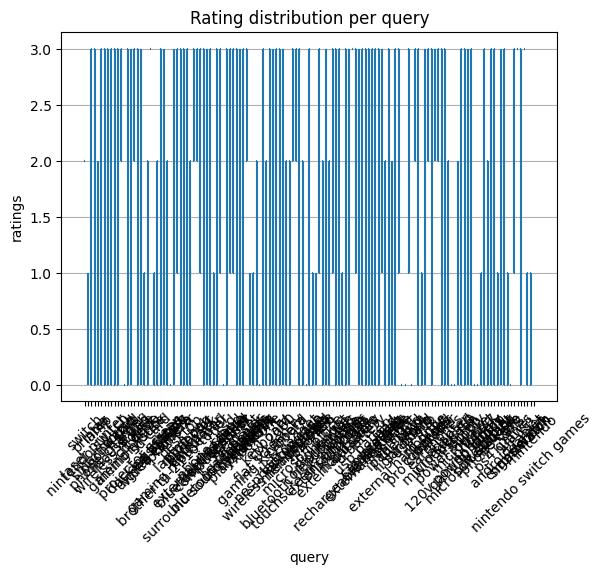

In [73]:
fig, axes = plt.subplots()
queries = df_overall['query'].unique()
dataset = [df_overall[df_overall['query'] == q]["rating"] for q in queries]

nb_queries = len(queries)

axes.violinplot(dataset = dataset, showmeans=True, bw_method=0.05)
axes.set_xlabel('query')
axes.set_ylabel('ratings')
axes.yaxis.grid(True)
axes.set_xticks(range(1,nb_queries+1))
axes.set_xticklabels(queries,rotation=45)
plt.title('Rating distribution per query')
plt.show()

### Rating distribution per rater

Assuming raters have seen the same <query,document> pairs and that they had the same guidelines, their ratings should be overall calibrated.  This is what we want to check here.   
We could easily detect outlier raters that rate very different to others, for example because they haven't really understood the guidelines.

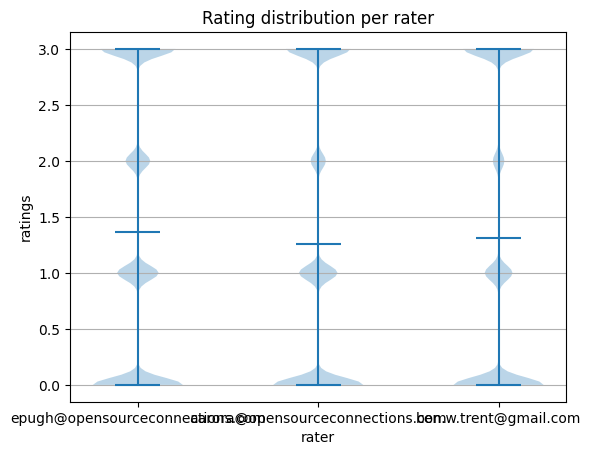

In [74]:
fig, axes = plt.subplots()
raters = df_overall['rater'].unique()
dataset = [df_overall[df_overall['rater'] == r]["rating"] for r in raters]

axes.violinplot(dataset = dataset, showmeans=True, bw_method=0.05)
axes.set_xlabel('rater')
axes.set_ylabel('ratings')
axes.yaxis.grid(True)
axes.set_xticks(range(1,nb_raters+1))
axes.set_xticklabels(raters)
plt.title('Rating distribution per rater')
plt.show()

## Ratings Analysis

We now focus on the ratings themselves.  We first plot the overall rating distributions

### Overall rating distribution

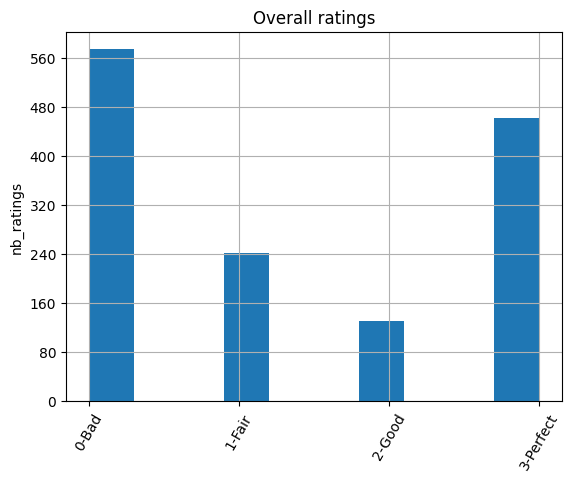

In [75]:
from matplotlib.ticker import MaxNLocator
plt.hist(df_overall['rating'])
plt.title('Overall ratings')
plt.xticks(range(len(ratings)), ratings,
       rotation=60) 
None
plt.ylabel('nb_ratings')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid()

### Agreements between raters
In this section we want to check how much raters agree or disagree.

  - If all raters agreeing on a rating will give us confidence about the rating
  - If all raters disagree, for example, 1 rating `Poor` another one rating `Fair` and the third one rating `Perfect`, then something draws our attention. Either the intent was not clear or raters did not rate as expected. 

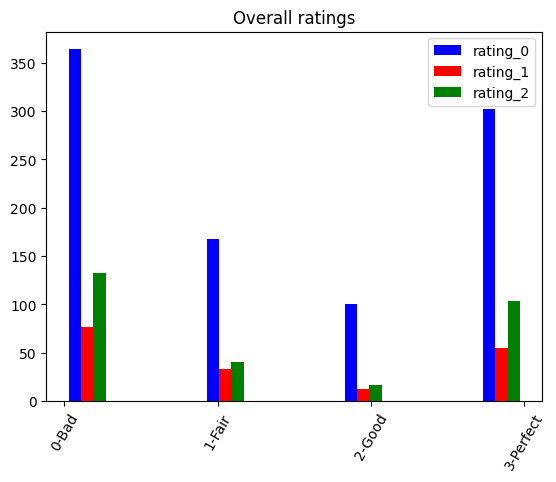

In [76]:
vals = []
labs = []
cols = []
for agent,col in (('rating_0','blue'),
                  ('rating_1','red'),
                  ('rating_2', 'green')
                 ):
    vals.append(df[agent])
    labs.append(agent)
    cols.append(col)
plt.hist(vals, color=cols, label=labs)

plt.legend()
plt.title('Overall ratings')
plt.xticks(range(len(ratings)), ratings, rotation=60) 
None

Text(0.5, 1.0, 'Agents agreements')

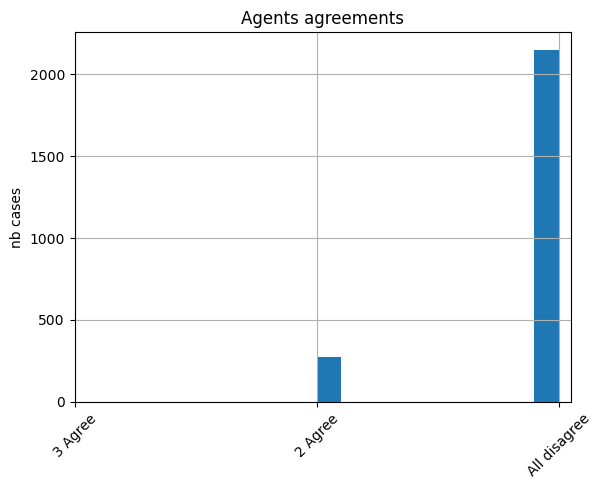

In [77]:
def nb_distinct_ratings(r):
    return len({r['rating_0'], r['rating_1'], r['rating_2']})
df['nb_distinct_ratings'] = df.apply(nb_distinct_ratings, axis=1)
df['nb_distinct_ratings'].hist()
plt.xticks([1, 2, 3], ['3 Agree', '2 Agree', 'All disagree'],
       rotation=45) 
plt.ylabel('nb cases')
plt.title('Agents agreements')

Some suspicious cases we will further investigate later on:

In [78]:
print('All disagree:')
df[df['nb_distinct_ratings']==3]

All disagree:


,query,docid,charlie@flax.co.uk,rating_0,eschramma@cas.org,dtaivpp@gmail.com,rating_1,cmcollier@gmail.com,rating_2,jeff@vin.com,cmarino@enterprise-knowledge.com,msfroh@gmail.com,peter@searchintuition.com,maximilian.werk@jina.ai,ryan.finley@ferguson.com,rater_0,rater_1,rater_2,nb_distinct_ratings
0,projector screen,325961,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,3
1,projector screen,47471,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,3
2,projector screen,126679,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,3
3,projector screen,254441,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,3
4,projector screen,325958,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2415,power supply,1667352,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,3
2416,power supply,1667804,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,3
2417,power supply,1667752,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,3
2418,power supply,1667821,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,3


Some cases where all raters agree, we can have good confidence in the rating:

In [79]:
# We have none that everyone agrees on
print('All agree:')
df[df['nb_distinct_ratings']==1].sample(5)

All agree:


<class 'ValueError'>: a must be greater than 0 unless no samples are taken

Not perfect but 2 / 3 raters agreed on the rating value:

In [80]:
# We have none
print('Majority agree:')
df[df['nb_distinct_ratings']==2]

Majority agree:


,query,docid,charlie@flax.co.uk,rating_0,eschramma@cas.org,dtaivpp@gmail.com,rating_1,cmcollier@gmail.com,rating_2,jeff@vin.com,cmarino@enterprise-knowledge.com,msfroh@gmail.com,peter@searchintuition.com,maximilian.werk@jina.ai,ryan.finley@ferguson.com,rater_0,rater_1,rater_2,nb_distinct_ratings
6,projector screen,549808,NaN,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,2
19,laptop,77031393,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,2
20,iphone 8,79283963,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,2
21,iphone 8,79284190,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,2
24,iphone 8,77911774,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,coffee,656359,NaN,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,2
1331,coffee,77265396,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,2
1334,coffee,2102472,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,2
1340,vans,77129498,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epugh@opensourceconnections.com,aarora@opensourceconnections.com,ben.w.trent@gmail.com,2


### Big discrepancies

Thos cases are the most suspicious ones. Some raters rated as `3-Perfect` some other rated as '1-Fair' or '0-Bad' (or at least a difference of 2 grades).
There can be several reasons for that:
  - there is an issue with the pair: query not clear, document not clear
  - guidelines not well specified: a very common case is when the guidelines are not 100% clear to the raters. For example, what happens if the image of the results is relevant but the text is not? Or if some document fields are missing?
  - no clear intent.  Was the intent of the query clear enough? This can cause confusion to the raters.  It's important to give an opportunity to the rater to say `I don't know how to rate this pair!`


In [81]:
def big_discrepancy(r):
    """returns 1 if there is at least one 2 grades between 1 rating and another, 0 otherwise"""
    ratings = [r[f'rating_{i}'] for i in range(nb_raters)]
    return 1 if  max(ratings) - min(ratings) >=2 else 0
df['big_discrepancy'] = df.apply(big_discrepancy, axis=1)
df[df['big_discrepancy']==1].sample(2)

<class 'ValueError'>: a must be greater than 0 unless no samples are taken

### Overall confusion between raters
Confusion analysis allows to understand the types of disagreements between raters. 
In a health rating setup we would expect to have most of the confusions between `0` and `1` or `1` and `2`.


In [82]:
y1 = []
y2 = []
for i,r in df.iterrows():
    #12
    y1.append(r['rating_0'])
    y2.append(r['rating_1'])

    

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y1, y2, labels=range(len(ratings)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=ratings)
plt.figure(figsize=(8,8))
disp.plot(xticks_rotation=45, colorbar=False, cmap=plt.cm.Blues, ax=plt.gca(), values_format='d')
plt.xlabel('');plt.ylabel('')
plt.gca().xaxis.tick_top()

<class 'ValueError'>: Input y_true contains NaN.

This work has been provided by Wallapop Search team (http://www.wallapop.com/).

_This notebook was last updated 16_January_2025_